In [ ]:
!pip install torchinfo

In [ ]:
import os
import time
import random

import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
from typing import Dict, List
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchinfo import summary

In [ ]:
train_dir = Path('/content/data/train/train')
val_dir = Path('/content/data/train/valid')
test_dir = Path('/content/data/test')

In [ ]:
train_data_filenames = sorted(os.listdir(train_dir))
train_data_filenames = [s for s in train_data_filenames if s != ".DS_Store"]

plants, diseases = [], []

for filename in train_data_filenames:
    plant, disease = filename.split("___")
    if plant not in plants:
        plants.append(plant)
    if disease not in diseases:
        if disease != "healthy":
            diseases.append(disease)

plants_table = pd.DataFrame(plants, columns=["Plants"])
diseases_table = pd.DataFrame(diseases, columns=["Diseases"])

In [ ]:
total_classes = len(train_data_filenames)

print(f"Total Classes: {total_classes}")

Total Classes: 38


In [ ]:
plants_table

,Plants
0,Apple
1,Blueberry
2,Cherry_(including_sour)
3,Corn_(maize)
4,Grape
5,Orange
6,Peach
7,"Pepper,_bell"
8,Potato
9,Raspberry


In [ ]:
diseases_table

,Diseases
0,Apple_scab
1,Black_rot
2,Cedar_apple_rust
3,Powdery_mildew
4,Cercospora_leaf_spot Gray_leaf_spot
5,Common_rust_
6,Northern_Leaf_Blight
7,Esca_(Black_Measles)
8,Leaf_blight_(Isariopsis_Leaf_Spot)
9,Haunglongbing_(Citrus_greening)


In [ ]:
nums = {}

for filename in train_data_filenames:
    nums[filename] = len(os.listdir(f"{train_dir}/{filename}"))

image_counts = pd.DataFrame(nums.values(), index=nums.keys(), columns=["Images Count"])

image_counts

,Images Count
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___Powdery_mildew,1683
Cherry_(including_sour)___healthy,1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___Northern_Leaf_Blight,1908


In [ ]:
def show_batch(data, fname):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

        plt.savefig(fname, bbox_inches='tight', transparent=True)
        break

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("Sample images before preprocessing")
show_batch(train_dataloader, "sample_images_before.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=232),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=232),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print("Sample images after preprocessing")
show_batch(train_dataloader, "sample_images_after.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

model.fc = nn.Sequential(nn.Linear(in_features=model.fc.in_features, out_features=38))

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Device used: {device}")

Device used: cuda


In [ ]:
summary(model=model, input_size=(32, 3, 232, 232))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 38]                  --
├─Conv2d: 1-1                            [32, 64, 116, 116]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 116, 116]        (128)
├─ReLU: 1-3                              [32, 64, 116, 116]        --
├─MaxPool2d: 1-4                         [32, 64, 58, 58]          --
├─Sequential: 1-5                        [32, 256, 58, 58]         --
│    └─Bottleneck: 2-1                   [32, 256, 58, 58]         --
│    │    └─Conv2d: 3-1                  [32, 64, 58, 58]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 58, 58]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 58, 58]          --
│    │    └─Conv2d: 3-4                  [32, 64, 58, 58]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 58, 58]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 58, 58]   

In [ ]:
epochs = 10
min_lr = 0.001
max_lr = 0.01
weight_decay = 1e-5

torch.manual_seed(99)
torch.cuda.manual_seed(99)

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=min_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dataloader))

In [ ]:
def evaluate(y, y_pred):
    y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    return (y == y_pred).sum().item()/len(y_pred)

In [ ]:
def train():
    model.train()

    train_loss, train_accuracy = 0, 0

    print("\nTraining...")

    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        loss.backward()

        nn.utils.clip_grad_value_(model.parameters(), 0.1)

        optimizer.step()
        optimizer.zero_grad()

        scheduler.step()

        train_accuracy += evaluate(y, y_pred)

    return (train_loss / len(train_dataloader)), (train_accuracy / len(train_dataloader))

In [ ]:
def validate():
    model.eval()

    val_loss, val_accuracy = 0, 0

    print("Validating...")

    with torch.inference_mode():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)

            y_pred = model(x)

            loss = loss_function(y_pred, y)
            val_loss += loss.item()

            val_accuracy += evaluate(y, y_pred)

    return (val_loss / len(val_dataloader)), (val_accuracy / len(val_dataloader))

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train()
  val_loss, val_acc = validate()

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f"Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]


Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 0: Training Loss: 0.9041, Training Accuracy: 0.8633, Validation Loss: 0.2655, Validation Accuracy: 0.9493

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.1962, Training Accuracy: 0.9441, Validation Loss: 0.1471, Validation Accuracy: 0.9520

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.2113, Training Accuracy: 0.9377, Validation Loss: 0.1803, Validation Accuracy: 0.9477

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.2069, Training Accuracy: 0.9431, Validation Loss: 0.1678, Validation Accuracy: 0.9513

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.1740, Training Accuracy: 0.9512, Validation Loss: 0.1252, Validation Accuracy: 0.9632

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.1507, Training Accuracy: 0.9583, Validation Loss: 0.1509, Validation Accuracy: 0.9577

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 6: Training Loss: 0.1168, Training Accuracy: 0.9649, Validation Loss: 0.1127, Validation Accuracy: 0.9670

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 7: Training Loss: 0.0892, Training Accuracy: 0.9714, Validation Loss: 0.0888, Validation Accuracy: 0.9727

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 8: Training Loss: 0.0687, Training Accuracy: 0.9779, Validation Loss: 0.0774, Validation Accuracy: 0.9755

Training...


  0%|          | 0/2197 [00:00<?, ?it/s]

Validating...


  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 9: Training Loss: 0.0618, Training Accuracy: 0.9796, Validation Loss: 0.0767, Validation Accuracy: 0.9762


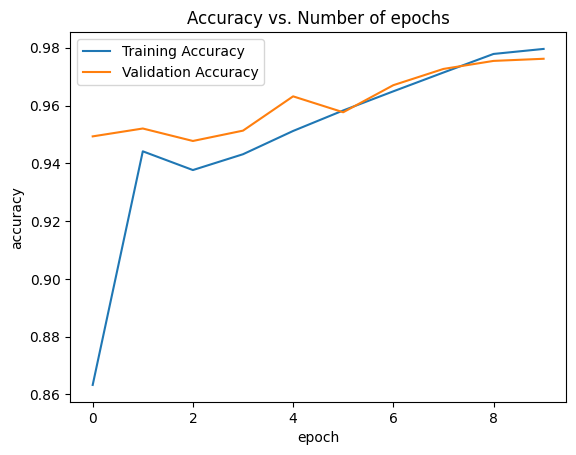

In [ ]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Number of epochs')
plt.legend()

plt.savefig("accuracies.png")

plt.show()

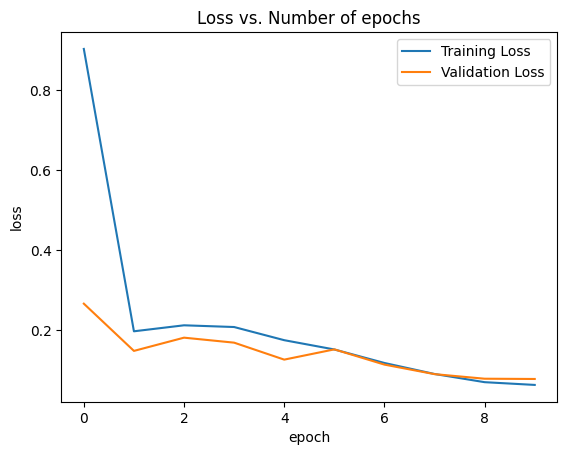

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. Number of epochs')
plt.legend()

plt.savefig("losses.png")

plt.show()

In [ ]:
torch.save(obj=model.state_dict(), f="plant_diseases_classification.pth")

In [ ]:
preprocess_test = transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=232),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_dataset = datasets.ImageFolder(test_dir)

In [ ]:
def predict_image(image, index):
  plt.imshow(image)
  image = preprocess_test(image)
  image = image.unsqueeze(0)
  image = image.to(device)

  with torch.no_grad():
        outputs = model(image)

        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_label = train_dataset.classes[predicted.item()]

        plt.title(f"Prediction: {predicted_label}, Confidence: {confidence[predicted.item()]:.2f}%")
        plt.axis("off")
        plt.savefig(f"test/{index}.png")
        plt.show()

In [ ]:
for index, (img, label) in enumerate(test_dataset):
  predict_image(img, index)

Output hidden; open in https://colab.research.google.com to view.